In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [11]:
train = pd.read_csv("../../mlcourse/data_kaggel/playground-series-s4e11/train.csv")
test = pd.read_csv("../../mlcourse/data_kaggel/playground-series-s4e11/test.csv")

In [12]:
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [13]:
train.shape

(140700, 20)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

## Cat. features

In [15]:
train.columns[train.dtypes == "object"]

Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')

### cat_col

In [16]:
train["Gender"].value_counts()

Gender
Male      77464
Female    63236
Name: count, dtype: int64

In [17]:
train["Working Professional or Student"].value_counts()

Working Professional or Student
Working Professional    112799
Student                  27901
Name: count, dtype: int64

In [18]:
train["Have you ever had suicidal thoughts ?"].value_counts()

Have you ever had suicidal thoughts ?
No     71138
Yes    69562
Name: count, dtype: int64

In [19]:
train["Gender"] = train["Gender"].map({
    "Male": 0,
    "Female": 1
})

train["Working Professional or Student"] = train["Working Professional or Student"].map({
    "Working Professional": 0,
    "Student": 1
})

train["Have you ever had suicidal thoughts ?"] = train["Have you ever had suicidal thoughts ?"].map({
    "Yes": 1,
    "No": 0
})

In [20]:
train["Family History of Mental Illness"] = train["Family History of Mental Illness"].map({
    "No": 0,
    "Yes": 1
})

In [21]:
train.select_dtypes(include=["object"]).columns

Index(['Name', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits',
       'Degree'],
      dtype='object')

In [22]:
cat_col = list(train.columns[train.dtypes == "object"])

In [23]:
for col in cat_col:
    l = len(train[col].unique())
    print(col, l)

Name 422
City 98
Profession 65
Sleep Duration 36
Dietary Habits 24
Degree 116


## Plots

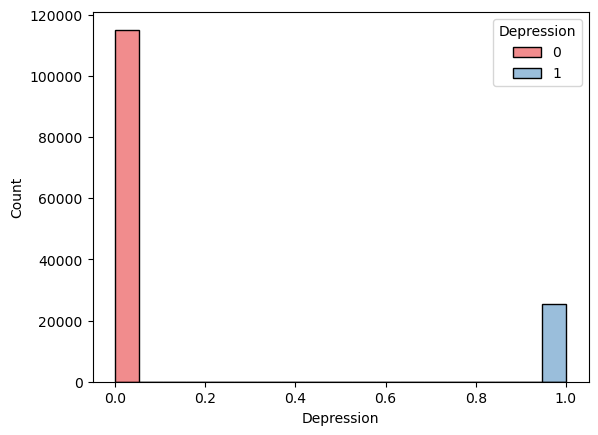

In [24]:
sns.histplot(data=train, x=train["Depression"], hue="Depression", palette="Set1");

In [25]:
train["Depression"].value_counts()

Depression
0    115133
1     25567
Name: count, dtype: int64

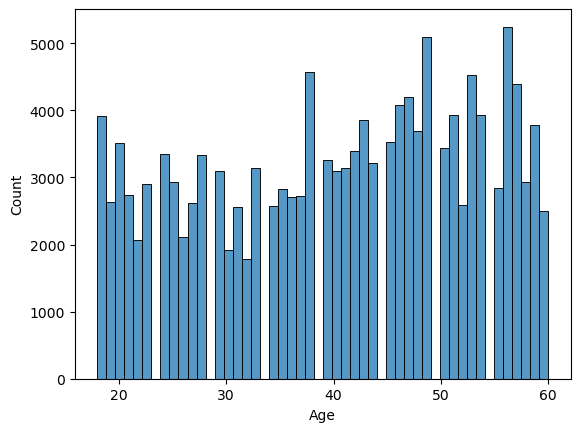

In [26]:
sns.histplot(data=train, x=train["Age"]);

## NaN

In [27]:
train.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [28]:
train.columns[train.isnull().sum() > 0]

Index(['Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Dietary Habits', 'Degree',
       'Financial Stress'],
      dtype='object')

In [29]:
train_df = train.copy().drop(columns=["Name"], axis=1)

In [30]:
train.shape

(140700, 20)

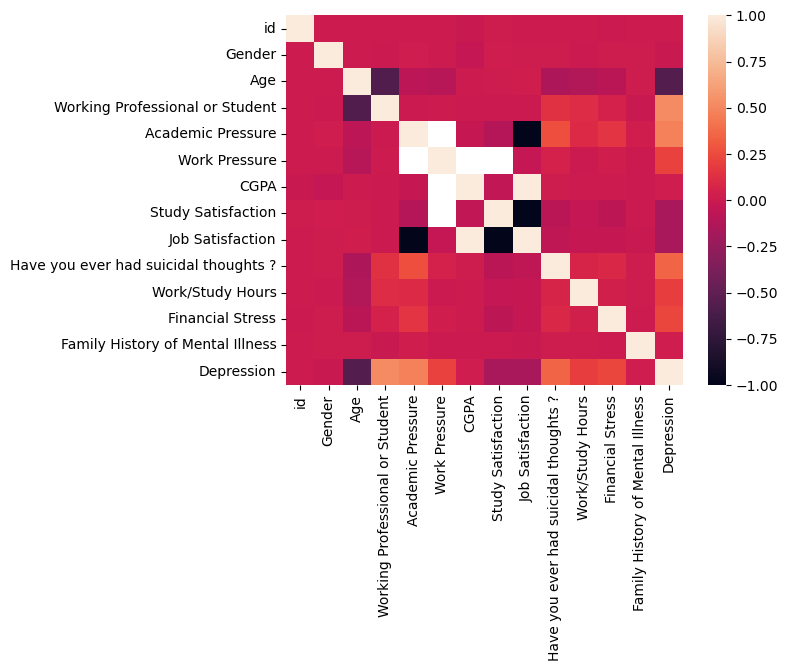

In [31]:
corr_matrix =  train.select_dtypes(exclude=["object"]).corr()
sns.heatmap(data=corr_matrix);

In [32]:
from scipy import stats

In [33]:
train_df["Dietary Habits"].fillna(train_df["Dietary Habits"].mode()[0], inplace=True)
train_df["Degree"].fillna(train_df["Degree"].mode()[0], inplace=True)
train_df["Financial Stress"].fillna(train_df["Financial Stress"].mode()[0], inplace=True);

In [34]:
train_df.isnull().sum()

id                                            0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                0
Degree                                        0
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              0
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [35]:
train_df["Job Satisfaction"].unique()

array([ 2.,  3., nan,  1.,  5.,  4.])

## -nan

In [36]:
train_df_drop = train_df.copy().drop(columns=["Profession", "Academic Pressure", "Work Pressure", "CGPA", "Study Satisfaction", "Job Satisfaction"], axis=1)

In [37]:
train_df_drop.shape

(140700, 13)

In [38]:
train_df_drop.select_dtypes(include=["object"]).columns

Index(['City', 'Sleep Duration', 'Dietary Habits', 'Degree'], dtype='object')

In [39]:
train_df_drop.isnull().sum()

id                                       0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [40]:
from sklearn.model_selection import StratifiedKFold

In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42, )

In [42]:
import warnings

In [43]:
def mean_target_enc(train_df, y_train, valid_df, skf):
    warnings.filterwarnings("ignore")
    global_mean = y_train.mean()
    train_df = pd.concat([train_df, pd.Series(y_train, name="y")], axis=1)
    object_col = train_df.select_dtypes(include="object").columns.tolist()
    new_train_df = train_df.copy()
    for col in object_col:
        new_train_df[col + "_global_mean"] = [global_mean for _ in range(new_train_df[0])]
        
    